In [0]:



import os

if os.path.exists("physionet.org/files/challenge-2017/1.0.0/training/") == False:
  ! wget -r -N -c -np -nv -q https://physionet.org/files/challenge-2017/1.0.0/

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy import signal
from tqdm import tqdm
import torch
import psutil
import gc


if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on GPU -", device )
else:
  device = torch.device("cpu")
  print("Running on CPU -", device )

# to run on gpu .to(device)

REBUILD_DATA = True # processing data

Running on GPU - cuda:0


In [0]:
"""
Copyright (c) 2013 Jami Pekkanen

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

import sys
import numpy as np
import scipy.signal
import scipy.ndimage

def detect_beats(
		ecg,	# The raw ECG signal
		rate,	# Sampling rate in HZ
		# Window size in seconds to use for 
		ransac_window_size=5.0,
		# Low frequency of the band pass filter
		lowfreq=5.0,
		# High frequency of the band pass filter
		highfreq=15.0,
		):
	"""
	ECG heart beat detection based on
	http://link.springer.com/article/10.1007/s13239-011-0065-3/fulltext.html
	with some tweaks (mainly robust estimation of the rectified signal
	cutoff threshold).
	"""

	ransac_window_size = int(ransac_window_size*rate)

	lowpass = scipy.signal.butter(1, highfreq/(rate/2.0), 'low')
	highpass = scipy.signal.butter(1, lowfreq/(rate/2.0), 'high')
	# TODO: Could use an actual bandpass filter
	ecg_low = scipy.signal.filtfilt(*lowpass, x=ecg)
	ecg_band = scipy.signal.filtfilt(*highpass, x=ecg_low)
	
	# Square (=signal power) of the first difference of the signal
	decg = np.diff(ecg_band)
	decg_power = decg**2
	
	# Robust threshold and normalizator estimation
	thresholds = []
	max_powers = []
	for i in range(int(len(decg_power)/ransac_window_size)):
		sample = slice(i*ransac_window_size, (i+1)*ransac_window_size)
		d = decg_power[sample]
		thresholds.append(0.5*np.std(d))
		max_powers.append(np.max(d))

	threshold = np.median(thresholds)
	max_power = np.median(max_powers)
	decg_power[decg_power < threshold] = 0

	decg_power /= max_power
	decg_power[decg_power > 1.0] = 1.0
	square_decg_power = decg_power**2

	shannon_energy = -square_decg_power*np.log(square_decg_power)
	shannon_energy[~np.isfinite(shannon_energy)] = 0.0

	mean_window_len = int(rate*0.125+1)
	lp_energy = np.convolve(shannon_energy, [1.0/mean_window_len]*mean_window_len, mode='same')
	#lp_energy = scipy.signal.filtfilt(*lowpass2, x=shannon_energy)
	
	lp_energy = scipy.ndimage.gaussian_filter1d(lp_energy, rate/8.0)
	lp_energy_diff = np.diff(lp_energy)

	zero_crossings = (lp_energy_diff[:-1] > 0) & (lp_energy_diff[1:] < 0)
	zero_crossings = np.flatnonzero(zero_crossings)
	zero_crossings -= 1
	return zero_crossings

In [0]:
class Data_PreProcessing():
  ECG_PADDING = 90
  ECG_LENGTH = ECG_PADDING*2
  DATA = "physionet.org/files/challenge-2017/1.0.0/training/"
  NORMAL = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-normal" 
  AF = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-af"
  OTHER = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-other"
  NOISY = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-noisy"
  LABELS = {NORMAL: 0, AF: 1, OTHER:2, NOISY: 3}
  trainingData = []
  dataCount = {NORMAL: 0, AF: 0, OTHER: 0, NOISY: 0}


  def make_training_data(self):
    for records in self.LABELS:
      with open(records) as label:
        for ecgFile in tqdm(label):

          path = self.DATA+ecgFile[:-1]
          metadata = open(path+".hea", "r").read().split(" ")
          ecg_list = loadmat(path)['val'][0]

          for peak in detect_beats(ecg_list, float(metadata[2])):
            try:
              ecg = np.array(ecg_list[peak-self.ECG_PADDING:peak+self.ECG_PADDING])
              ecg = ecg / np.amax(abs(ecg))

              ecg = self.zero_padding(ecg) # what to call for fucntion
              
              augmented_ecg = self.zero_padding(self.resampling(self.rnd_zero(ecg)))
              augmented_ecg = augmented_ecg / np.amax(abs(augmented_ecg))


              #self.trainingData.append([ecgWave, self.LABELS[records]]) # CrossEntropyLoss()
              self.trainingData.append([ecg, np.eye(len(self.LABELS))[self.LABELS[records]]]) # MSELoss()
              self.trainingData.append([augmented_ecg, np.eye(len(self.LABELS))[self.LABELS[records]]])
              self.dataCount[records] += 2
            except Exception as e:
              #print(e)
              pass
    print(self.dataCount)
    total = sum(self.dataCount.values())
    for lbl in self.dataCount:
      print(lbl[80:]+": ", round(self.dataCount[lbl]/total*100, 2))
    print("Total: "+ str(total))

    np.random.shuffle(self.trainingData)
    np.save("trainingDataUNBALANCED.npy", self.trainingData)

    balanced_data = []
    count = [0,0,0,0]
    for e in self.trainingData:
      if count[np.argmax(e[1])] < 17340:
        count[np.argmax(e[1])] +=1
        balanced_data.append(e)
    
    np.random.shuffle(balanced_data)
    np.save("trainingData.npy", balanced_data)


  def rnd_zero(self, ecg):
    peak = np.argmax(ecg)
    for x in range(np.random.randint(5)):
      try:
        if np.random.randint(2) == 0:
          end = np.random.randint(peak-15)
          length = np.random.randint(7)+5
          ecg[end-length:end] = [0]*length
        else:
          start = np.random.randint(92)+115
          length = np.random.randint(7)+5
          ecg[start:start+length] = [0]*length
      except:
        pass
    return ecg

  def resampling(self, ecg):
	  MARGIN = 60
	  return signal.resample(ecg, np.random.randint(MARGIN)+(self.ECG_LENGTH-MARGIN))
   
  def zero_padding(self, ecg):
    if len(ecg) != self.ECG_LENGTH:
      ecg = np.append(ecg, [0]*(self.ECG_LENGTH-len(ecg)))
    return ecg

data = Data_PreProcessing()

if REBUILD_DATA:
  data.make_training_data()

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in multiply
48it [00:00, 73.18it/s]


FileNotFoundError: ignored

In [0]:
class Data_PreProcessing():
  ECG_PADDING = 90
  ECG_LENGTH = ECG_PADDING*2
  DATA = "physionet.org/files/challenge-2017/1.0.0/training/"
  NORMAL = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-normal" 
  AF = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-af"
  OTHER = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-other"
  NOISY = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-noisy"
  LABELS = {NORMAL: 0, AF: 1, OTHER:2, NOISY: 3}
  trainingData = []
  dataCount = {NORMAL: 0, AF: 0, OTHER: 0, NOISY: 0}


  def make_training_data(self):
    for records in self.LABELS:
      try:
        np.save(f"{records}.npy", self.trainingData)
      except Exception as e:
              print(e)
      count = 0
      with open(records) as label:
        for ecgFile in tqdm(label):
          if count > 17340:
              break
          else:
            count += 2
          path = self.DATA+ecgFile[:-1]
          metadata = open(path+".hea", "r").read().split(" ")
          ecg_list = loadmat(path)['val'][0]

          for peak in detect_beats(ecg_list, float(metadata[2])):

            try:
              ecg = np.array(ecg_list[peak-self.ECG_PADDING:peak+self.ECG_PADDING])
              augmented_ecg = self.zero_padding(self.resampling(self.rnd_zero(ecg)))
              ecg = ecg / np.amax(abs(ecg))
              ecg = self.zero_padding(ecg) # what to call for fucntion  
              ecg = (ecg * 90) + 90
              img = np.array([[[0 for i in range(181)] for i in range(181)]][0])
              c = 0
              for x in ecg:
                img[int(x)][c] = 1
                c+=1
              
              augmented_ecg = augmented_ecg / np.amax(abs(augmented_ecg))
              augmented_ecg = (augmented_ecg * 90) + 89
              augmented_img = np.array([[[0 for i in range(181)] for i in range(181)]][0])
              c = 0
              for x in augmented_ecg:
                img[int(x)][c] = 1
                c+=1
              #self.trainingData.append([ecgWave, self.LABELS[records]]) # CrossEntropyLoss()
              self.trainingData.append([img, np.eye(len(self.LABELS))[self.LABELS[records]]]) # MSELoss()
              self.trainingData.append([augmented_img, np.eye(len(self.LABELS))[self.LABELS[records]]])
              self.dataCount[records] += 2
            except Exception as e:
              pass
    print(self.dataCount)
    total = sum(self.dataCount.values())
    for lbl in self.dataCount:
      print(lbl[80:]+": ", round(self.dataCount[lbl]/total*100, 2))
    print("Total: "+ str(total))

    np.random.shuffle(self.trainingData)
    np.save("trainingDataUNBALANCED.npy", self.trainingData)

    balanced_data = []
    count = [0,0,0,0]
    for e in self.trainingData:
      if count[np.argmax(e[1])] < 17340:
        count[np.argmax(e[1])] +=1
        balanced_data.append(e)
    
    np.random.shuffle(balanced_data)
    np.save("trainingData.npy", balanced_data)


  def rnd_zero(self, ecg):
    peak = np.argmax(ecg)
    for x in range(np.random.randint(5)):
      try:
        if np.random.randint(2) == 0:
          end = np.random.randint(peak-15)
          length = np.random.randint(7)+5
          ecg[end-length:end] = [0]*length
        else:
          start = np.random.randint(92)+115
          length = np.random.randint(7)+5
          ecg[start:start+length] = [0]*length
      except:
        pass
    return ecg

  def resampling(self, ecg):
	  MARGIN = 60
	  return signal.resample(ecg, np.random.randint(MARGIN)+(self.ECG_LENGTH-MARGIN))
   
  def zero_padding(self, ecg):
    if len(ecg) != self.ECG_LENGTH:
      ecg = np.append(ecg, [0]*(self.ECG_LENGTH-len(ecg)))
    return ecg

data = Data_PreProcessing()

if REBUILD_DATA:
  data.make_training_data().to(device)

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in multiply
608it [02:33,  3.44it/s]

In [0]:
import psutil

print(psutil.virtual_memory()._asdict()["percent"])

6.6


In [0]:
print(data.trainingData)

180


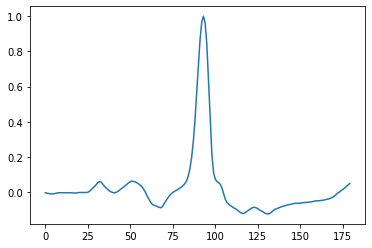

In [0]:

try:
  trainingData = np.load("trainingData.npy", allow_pickle=True)
except:
  trainingData = np.load("drive/My Drive/trainingData.npy", allow_pickle=True)
ecg = trainingData[0][0]
print(len(ecg))

plt.plot(ecg)

In [0]:
import psutil

t = []
print(len(trainingData))
counter = 0
j = 0
for x in tqdm(trainingData):
  if counter % 5000== 0:
    np.save(f"data{j}.npy", t)
    j +=1
    t = []

  if dict(psutil.virtual_memory()._asdict())["percent"] < 95:
    ecg = x[0]
    ecg = (ecg * 90) + 90
    img = np.array([[[0 for i in range(181)] for i in range(181)]][0])

    #print(ecg)
    c = 0
    for u in ecg:
      try:
        img[int(u)][c] = 1
      except Exception as e:
        print(e)
      c+=1
    #plt.imshow(img)
    t.append([np.array(img), x[1]])
    counter +=1


  0%|          | 30/34440 [00:00<01:56, 295.26it/s]

34440


100%|██████████| 34440/34440 [03:16<00:00, 175.71it/s]


10000


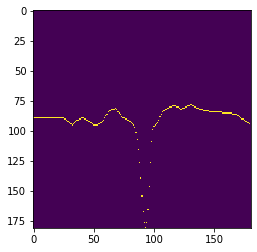

In [3]:
trainingData = []
for x in np.load("data1.npy", allow_pickle=True):
  trainingData.append(x)
for x in np.load("data2.npy", allow_pickle=True):
  trainingData.append(x)
'''
for x in np.load("data3.npy", allow_pickle=True):
  trainingData.append(x)
for x in np.load("data4.npy", allow_pickle=True):
  trainingData.append(x)
for x in np.load("data5.npy", allow_pickle=True):
  trainingData.append(x)
for x in np.load("data6.npy", allow_pickle=True):
  trainingData.append(x)     
'''
plt.imshow(trainingData[0][0])
print(len(trainingData))

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 180, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(180, 180, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(180, 90, 5)

        x = torch.randn(180,180).view(-1,1,180,180)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 1440) #flattening.
        self.fc2 = nn.Linear(1440, 4) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return x


net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(1, 180, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(180, 180, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(180, 90, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=32490, out_features=1440, bias=True)
  (fc2): Linear(in_features=1440, out_features=4, bias=True)
)


In [5]:
import torch.optim as optim

#optimizer = optim.Adam(net.parameters(), lr = 0.001)#, weight_decay=1e-5)

X = torch.Tensor([i[0] for i in trainingData])
y = torch.Tensor([i[1] for i in trainingData])
 
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

1000


In [6]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

train_data = trainingData[:-val_size]

test_data = trainingData[-val_size:]

print(len(train_X), len(test_X))

9000 1000


In [7]:
 # insample accuracy & insample loss
 # outsample accuracy & outsample loss
import torch.nn as nn

def fwd_pass(X, y, train=False):
  if train:
    net.zero_grad()
  outputs = net(X)
  matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss_function = nn.CrossEntropyLoss().to(device)
  loss = loss_function(outputs, torch.argmax(y, 1))
  if train:
    loss.backward()
    optimizer.step()
  return acc, loss

def test(size=32):
    X, y = test_X[:size], test_y[:size]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 180).to(device), y.to(device))
    return val_acc, val_loss

def net_info(net):
  params = []
  for layers, m in enumerate(net.modules()):
    params.append(int(''.join(filter(lambda x: x.isdigit(),str((str(m).split(',')[1]))))))

  return layers, params

def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

val_acc, val_loss = test(size=100)
print(val_acc, val_loss)

RuntimeError: ignored

In [0]:
import time

net = Net().apply(weight_reset).to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay=1e-5)
loss_function = nn.CrossEntropyLoss()#weight=1/torch.Tensor(list(Data_PreProcessing.dataCount.values())))

PATH = "/content/drive/My Drive/ECG_MODELS/"

layers, params = net_info(net)
MODEL_NAME = f"layers-{layers}_parms-{str(params)[1:-1].replace(', ', '_')}_model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time.

def train(net):
    BATCH_SIZE = 5000
    EPOCHS = 100

    with open(PATH+"data/"+f"{MODEL_NAME}.log", "a") as f:
        for epoch in tqdm(range(EPOCHS)):
            for i in range(0, len(train_X), BATCH_SIZE):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,180)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                #print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                #f.write(f"{MODEL_NAME},{round(time.time(),3)},train,{round(float(acc),2)},{round(float(loss),4)}\n")
                # just to show the above working, and then get out:
                
                if i % 50 == 0:
                    val_acc, val_loss = test(size=100)
                    f.write(f"{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)},{epoch}\n")
              
print(MODEL_NAME)
train(net)
torch.save(net, PATH+"model_params/"+f'{MODEL_NAME}.pt')

model_data = open(PATH+"model_data/"+f"{MODEL_NAME}.txt", "w")
model_data.write(str(net))
model_data.write("/n")
model_data.write(str(optimizer))
model_data.write("/n")
model_data.write(str(loss_function))
model_data.close()

In [0]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

PATH = "/content/drive/My Drive/ECG_MODELS/"

def create_acc_loss_graph(model_name):
  contents = open(PATH+"data/"+f"{MODEL_NAME}.log", "r").read().split("\n")
  times = []
  accuracies = []
  losses = []
  mean_loss = []
  mean_acc = []
  val_accs = []
  val_losses = []

  contents = (c.split(",") for c in contents[:-1])
  for temp in list(contents):

    times.append(float(temp[0]))
    accuracies.append(float(temp[1]))
    losses.append(float(temp[2]))
    
    val_accs.append(float(temp[3]))
    val_losses.append(float(temp[4]))

  times = (np.asarray(times) - min(times))
  times = times/np.amax(times)
  times = times * 100
  fig = plt.figure(figsize=(20, 10))
  ax1 = plt.subplot2grid((2,1), (0,0))
  ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

  ax1.set_ylim([0,1])
  ax1.set_ylabel('Accuracy (0.0-1.0)')
  ax1.plot(times, accuracies, label="Training Set Accuracy")
  ax1.plot(times, val_accs, label="Validation Set Accuracy")
  ax1.legend(loc=2)

  ax2.set_ylim([0,2])
  ax2.set_ylabel('Loss (0.0-2.0)')
  ax2.set_xlabel('Epochs (0-100)')
  ax2.plot(times, losses, label="Training Set Loss")
  ax2.plot(times, val_losses, label="Validation Set Loss")
  ax2.legend(loc=2)
  plt.savefig(PATH+"graphs/"+MODEL_NAME)
  plt.show()

create_acc_loss_graph(MODEL_NAME)